#### Stock Price Forecasting with LSTM (Long Short-Term Memory)

- This module loads historical Microsoft stock data, visualizes key features, preprocesses the data for time series modeling, and trains an LSTM-based neural network to predict future closing prices.
- The model is built using TensorFlow/Keras and evaluated by comparing predicted values against actual test data.

##### Import packages

In [ ]:
import os
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
import random
from sklearn.preprocessing import StandardScaler
from tensorflow import keras

##### Pre-steps

In [13]:
# Suppress TensorFlow warnings for cleaner output
os.environ["TF_CPP_MIN_LOG_LEVEL"] = '2'

# create folders
os.makedirs("plots", exist_ok=True)
os.makedirs("models", exist_ok=True)

In [14]:
# Load the dataset
data = pd.read_csv("MicrosoftStock.csv")

##### Quick data inspection

In [15]:
data.head()

,index,date,open,high,low,close,volume,Name
0,390198,2013-02-08,27.35,27.71,27.31,27.55,33318306,MSFT
1,390199,2013-02-11,27.65,27.92,27.50,27.86,32247549,MSFT
2,390200,2013-02-12,27.88,28.00,27.75,27.88,35990829,MSFT
3,390201,2013-02-13,27.93,28.11,27.88,28.03,41715530,MSFT
4,390202,2013-02-14,27.92,28.06,27.87,28.04,32663174,MSFT


In [16]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1259 entries, 0 to 1258
Data columns (total 8 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   index   1259 non-null   int64  
 1   date    1259 non-null   object 
 2   open    1259 non-null   float64
 3   high    1259 non-null   float64
 4   low     1259 non-null   float64
 5   close   1259 non-null   float64
 6   volume  1259 non-null   int64  
 7   Name    1259 non-null   object 
dtypes: float64(4), int64(2), object(2)
memory usage: 78.8+ KB


In [17]:
data.describe()

,index,open,high,low,close,volume
count,1259.000000,1259.000000,1259.000000,1259.000000,1259.000000,1.259000e+03
mean,390827.000000,51.026394,51.436007,50.630397,51.063081,3.386946e+07
std,363.586303,14.859387,14.930144,14.774630,14.852117,1.958979e+07
min,390198.000000,27.350000,27.600000,27.230000,27.370000,7.425603e+06
25%,390512.500000,40.305000,40.637500,39.870000,40.310000,2.254879e+07
50%,390827.000000,47.440000,47.810000,47.005000,47.520000,2.938758e+07
75%,391141.500000,59.955000,60.435000,59.275000,59.730000,3.842024e+07
max,391456.000000,95.140000,96.070000,93.720000,95.010000,2.483542e+08


In [18]:
# create a random int
rnd = random.randint(10**2, 10**3)

##### Visualization

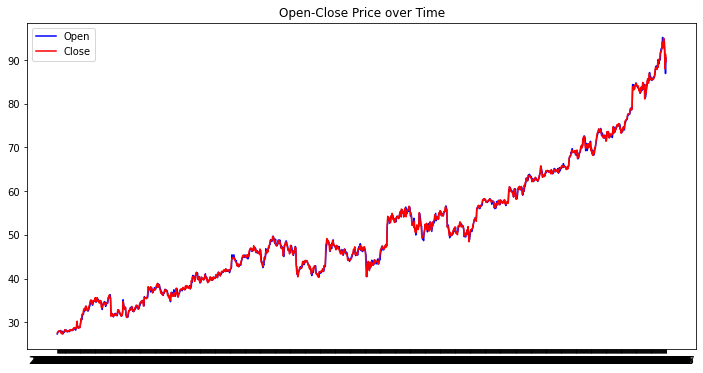

In [19]:
# Initial Visualization: Open vs Close prices
plt.figure(figsize=(12, 6))
plt.plot(data['date'], data['open'], label="Open", color="blue")
plt.plot(data['date'], data['close'], label="Close", color="red")
plt.title("Open-Close Price over Time")
plt.legend()
plt.savefig(f"plots/{rnd}_open_close_price.png")

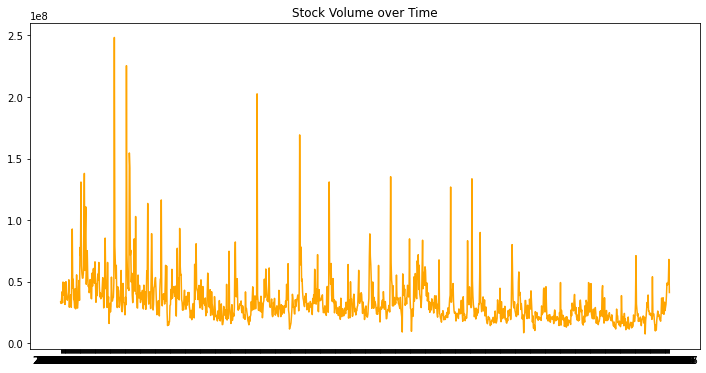

In [20]:
# Volume over time
plt.figure(figsize=(12, 6))
plt.plot(data['date'], data['volume'], label="Volume", color="orange")
plt.title("Stock Volume over Time")
plt.savefig(f"plots/{rnd}_open_close_price.png")

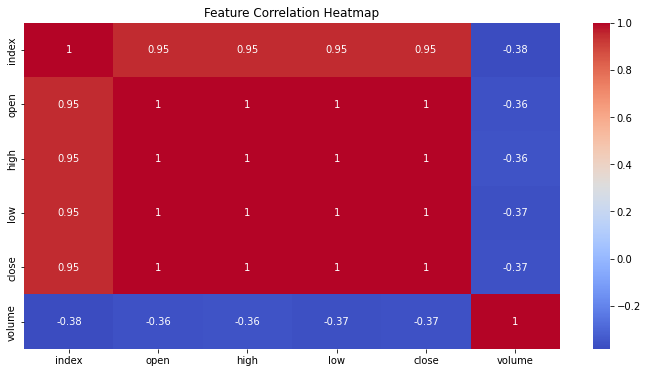

In [21]:
# Correlation heatmap for numeric features
numeric_data = data.select_dtypes(include=["int64", "float64"])
plt.figure(figsize=(12, 6))
sns.heatmap(numeric_data.corr(), annot=True, cmap="coolwarm")
plt.title("Feature Correlation Heatmap")
plt.savefig(f"plots/{rnd}_correlation_heatmap.png")

In [22]:
# Convert 'date' column to datetime format
data['date'] = pd.to_datetime(data['date'])

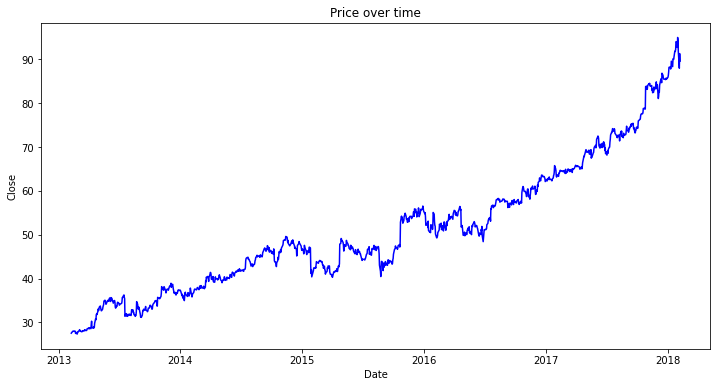

In [23]:
plt.figure(figsize=(12, 6))
plt.plot(data['date'], data['close'], color="blue")
plt.xlabel("Date")
plt.ylabel("Close")
plt.title("Price over time")
plt.savefig(f"plots/{rnd}_price_over_time.png")

In [24]:
# Prepare for the LSTM Model (Sequential)
stock_close = data.filter(["close"])
dataset = stock_close.values  # convert to numpy array
training_data_len = int(np.ceil(len(dataset) * 0.95))

In [25]:
# Preprocessing Stages
scaler = StandardScaler()
scaled_data = scaler.fit_transform(dataset)

training_data = scaled_data[:training_data_len]  # 95% of all out data

In [26]:
# Create a sliding window for our stock (60 days)
X_train, y_train = [], []
for i in range(60, len(training_data)):
    X_train.append(training_data[i-60:i, 0])
    y_train.append(training_data[i, 0])

In [27]:
X_train, y_train = np.array(X_train), np.array(y_train)

X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))

##### Build the Model

In [28]:

model = keras.models.Sequential()
model.add(keras.layers.LSTM(units=64, return_sequences=True,
          input_shape=(X_train.shape[1], 1)))
model.add(keras.layers.LSTM(64, return_sequences=False))
model.add(keras.layers.Dense(128, activation="relu"))
model.add(keras.layers.Dropout(0.5))
model.add(keras.layers.Dense(1))

In [29]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 60, 64)            16896     
                                                                 
 lstm_1 (LSTM)               (None, 64)                33024     
                                                                 
 dense (Dense)               (None, 128)               8320      
                                                                 
 dropout (Dropout)           (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 1)                 129       
                                                                 
Total params: 58369 (228.00 KB)
Trainable params: 58369 (228.00 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [30]:
model.compile(
    optimizer="adam",
    loss="mae",
    metrics=[keras.metrics.RootMeanSquaredError()]
)

In [31]:
training = model.fit(X_train, y_train, epochs=20, batch_size=32)

Epoch 1/20
36/36 [==============================] - 3s 22ms/step - loss: 0.2591 - root_mean_squared_error: 0.3798
Epoch 2/20
36/36 [==============================] - 1s 18ms/step - loss: 0.1351 - root_mean_squared_error: 0.1849
Epoch 3/20
36/36 [==============================] - 1s 19ms/step - loss: 0.1243 - root_mean_squared_error: 0.1698
Epoch 4/20
36/36 [==============================] - 1s 18ms/step - loss: 0.1212 - root_mean_squared_error: 0.1645
Epoch 5/20
36/36 [==============================] - 1s 18ms/step - loss: 0.1265 - root_mean_squared_error: 0.1703
Epoch 6/20
36/36 [==============================] - 1s 18ms/step - loss: 0.1150 - root_mean_squared_error: 0.1554
Epoch 7/20
36/36 [==============================] - 1s 18ms/step - loss: 0.1122 - root_mean_squared_error: 0.1511
Epoch 8/20
36/36 [==============================] - 1s 18ms/step - loss: 0.1098 - root_mean_squared_error: 0.1506
Epoch 9/20
36/36 [==============================] - 1s 19ms/step - loss: 0.1068 - root_m

In [ ]:
model.save(f"models/{rnd}_stock_lstm_model.h5")

##### Test the model

In [33]:
# Prep the test data
test_data = scaled_data[training_data_len - 60:]
X_test, y_test = [], dataset[training_data_len:]


for i in range(60, len(test_data)):
    X_test.append(test_data[i-60:i, 0])

In [34]:
X_test = np.array(X_test)
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))

In [35]:
# Make a Prediction
predictions = model.predict(X_test)
predictions = scaler.inverse_transform(predictions)

2/2 [==============================] - 0s 7ms/step


In [36]:
# Plotting data
train = data[:training_data_len]
test = data[training_data_len:]

In [37]:
test = test.copy()

test['Predictions'] = predictions

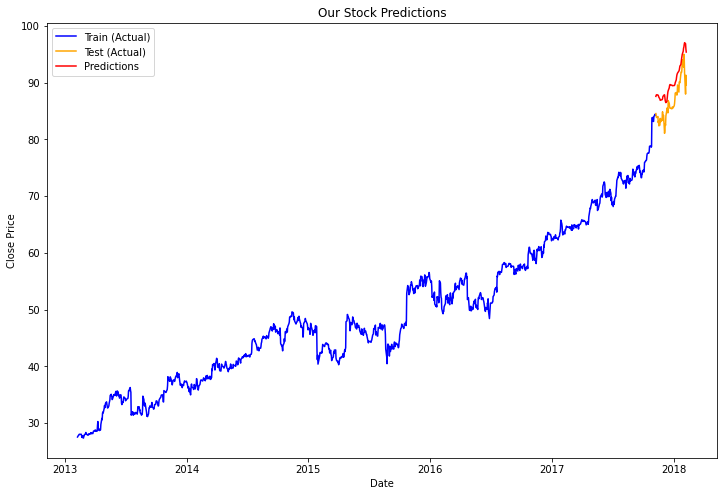

In [38]:
plt.figure(figsize=(12, 8))
plt.plot(train['date'], train['close'], label="Train (Actual)", color='blue')
plt.plot(test['date'], test['close'], label="Test (Actual)", color='orange')
plt.plot(test['date'], test['Predictions'], label="Predictions", color='red')
plt.title("Our Stock Predictions")
plt.xlabel("Date")
plt.ylabel("Close Price")
plt.legend()
plt.savefig(f"plots/{rnd}_stock_predictions.png")